In [1]:
import json
import logging
import os
from  nltk import ngrams
import multiprocessing as mp
import matplotlib.pyplot
from math import log

In [2]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [3]:
def getUpper(word):

    word = word[0].upper() + word[1:]
    return word

In [4]:
DEFAULT_MALE_SPECIAL = ['beard','ejaculation','erection']
DEFAULT_FEMALE_SPECIAL = ['pregnant','pregnancy','breast','abortion','miscarriage','menopause','dowry','bra']

DEFAULT_MALE_SPECIAL += [getUpper(w) for w in DEFAULT_MALE_SPECIAL]
DEFAULT_FEMALE_SPECIAL += [getUpper(w) for w in DEFAULT_FEMALE_SPECIAL]

In [5]:
# gender pair list taken from GN-Glove
DEFAULT_MALE_NOUNS = load_doc('male_word_file2.txt').split('\n')
DEFAULT_FEMALE_NOUNS = load_doc('female_word_file2.txt').split('\n')

DEFAULT_MALE_NOUNS += [getUpper(w) for w in DEFAULT_MALE_NOUNS if len(w)>0]
DEFAULT_FEMALE_NOUNS += [getUpper(w) for w in DEFAULT_FEMALE_NOUNS if len(w)>0]

DEFAULT_MALE_NOUNS = [w for w in DEFAULT_MALE_NOUNS if w not in DEFAULT_MALE_SPECIAL]
DEFAULT_FEMALE_NOUNS = [w for w in DEFAULT_FEMALE_NOUNS if w not in DEFAULT_FEMALE_SPECIAL]

In [6]:
def gender_ratios_m_f(output_data_dir,file, model,maleCount, femaleCount):
    #n = 0
    #tot = 0 
    scoresP = []
    scoresPC = []
    with open(file,'r') as f:
        data = json.load(f)
    bias_record = {}
    for words in data:
        if (data[words]['m']+data[words]['f'] > MinCount):
            if words in DEFAULT_MALE_SPECIAL or words in DEFAULT_FEMALE_SPECIAL:
                pm = data[words]['m'] / maleCount
                pf = data[words]['f'] / femaleCount
                if words in DEFAULT_MALE_SPECIAL:
                    score = log((data[words]['m']+1)/(data[words]['f']+1))
                    score_c = log((pm+0.0001)/(pf+0.0001))
                elif words in DEFAULT_FEMALE_SPECIAL:
                    score = log((data[words]['f']+1)/(data[words]['m']+1))
                    score_c = log((pf+0.0001)/(pm+0.0001))
                scoresP.append(score)
                scoresPC.append(score_c)
                bias_record[words] = (log((data[words]['m']+1)/(data[words]['f']+1)),data[words]['m']+data[words]['f'])
    output_file = os.path.join(output_data_dir, 'biased_words_m_f' + model)   
    with open(output_file,'w') as fp:
        json.dump(bias_record,fp, sort_keys=True) 
    print('words considered: ',len(scoresP))
    print("Preservation_score_P: ", (sum(scoresP)/len(scoresP)))
    print("Preservation_score_PC: ", (sum(scoresPC)/len(scoresPC)))
    return scoresP,scoresPC,bias_record

In [7]:
# Taken from jtcrammer repo
def get_cooccurrences(file, data, window):           
       
    with open(file, 'r') as fp:
        sentences = fp.read()
        
    male_nouns = DEFAULT_MALE_NOUNS
    female_nouns = DEFAULT_FEMALE_NOUNS
    n_grams = ngrams(sentences.split(), window)
    
    for grams in n_grams:
        pos = 1
        m = 0 
        f = 0 
        for w in grams:
                pos+=1
                if w not in data:
                    data[w]= {"m":0, "f":0}
                
                if pos==int((window+1)/2):
                    if w in male_nouns:
                        m = 1
                    if w in female_nouns:
                        f = 1
                    if m > 0:
                        for t in grams:
                            if t not in data:
                                data[t]= {"m":0, "f":0}
                            data[t]['m']+=1
                    if f > 0:
                        for t in grams:
                            if t not in data:
                                data[t]= {"m":0, "f":0}
                            data[t]['f']+=1
    return data

In [8]:
def getGenderCounts(file):
    with open(file, 'r') as fp:
        sentences = fp.read()
    tokens = sentences.split()
    maleCount = len([w for w in tokens if w in DEFAULT_MALE_NOUNS])
    femaleCount = len([w for w in tokens if w in DEFAULT_FEMALE_NOUNS])
    return maleCount,femaleCount

In [19]:
output_data_dir = './Bias/'
txtDir = './generated_10000/generated_10000/'
models = os.listdir(txtDir)
models

['model_0',
 'model_0.01',
 'model_0.1',
 'model_0.5',
 'model_0.8',
 'model_1',
 'model_2',
 'model_5',
 'model_cda_0',
 'model_cda_0.5']

In [20]:
window=10
MinCount = 20

In [17]:
biasPList = []
biasPCList = []
scorePList = []
scorePCList = []
scoreDictList = []
maleRatio = []
for m in models:
    data ={}
    print("Processing: ",m)
    print("Files:",len(os.listdir(txtDir + m)))
    maleCount = 0
    femaleCount = 0
    for file in os.listdir(txtDir + m)[:10000]:
        txt_path = txtDir + m + '/' + file
        data = get_cooccurrences(txt_path, data, window)
        mCount,fCount = getGenderCounts(txt_path)
        maleCount += mCount
        femaleCount += fCount
    output_file = output_data_dir + m + '.json'
    with open(output_file,'w') as fp:
        json.dump(data,fp)
    print('male word ratio :', maleCount/(maleCount+femaleCount))
    maleRatio.append(maleCount/(maleCount+femaleCount))
    scores_p,scores_pc,scores_dict = gender_ratios_m_f(output_data_dir,output_file, m, maleCount, femaleCount)
    scorePList.append(scores_p)
    scorePCList.append(scores_pc)
    scoreDictList.append(scores_dict)
    biasPList.append(sum(scores_p)/len(scores_p))
    biasPCList.append(sum(scores_pc)/len(scores_pc))

Processing:  model_cda_2
Files: 10000
male word ratio : 0.5015985112372954
words considered:  3
Bias_score_P:  -0.0029822619966020946
Bias_score_PC:  -0.0006794488421130833


In [28]:
## Just arranging model names by lambda
mm = ['lambda_0','cda', 'lambda_0.01','lambda_0.1', 'lambda_0.5', 'lambda_0.8',\
      'lambda_1', 'lambda_2', 'lambda_5']
scorePList = [dict(zip(models,scorePList))[m] for m in mm]
scorePCList = [dict(zip(models,scorePCList))[m] for m in mm]
biasPList = [dict(zip(models,biasPList))[m] for m in mm]
biasPCList = [dict(zip(models,biasPCList))[m] for m in mm]
maleRatio = [dict(zip(models,maleRatio))[m] for m in mm]
modelsNames = mm

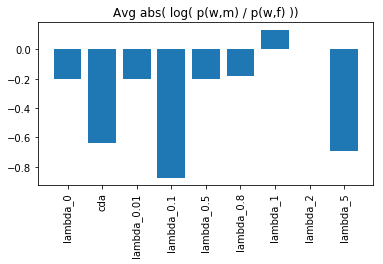

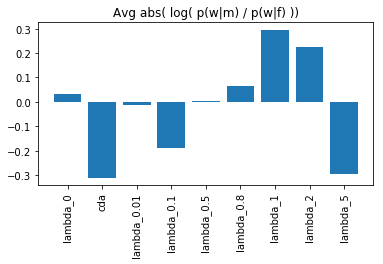

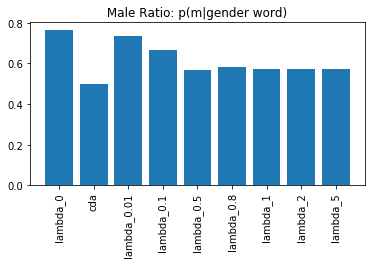

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasPList)
plt.title('Avg abs( log( p(w,m) / p(w,f) ))')
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasPCList)
plt.title('Avg abs( log( p(w|m) / p(w|f) ))')
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(modelsNames, maleRatio)
plt.title(' Male Ratio: p(m|gender word) ')
_=plt.xticks(modelsNames, rotation='vertical')

[('beard', 1), ('pregnant', 10)]
[('pregnant', 5), ('beard', 1)]
[('pregnant', 13)]
[('pregnant', 9)]
[('pregnant', 10), ('beard', 1)]
[('beard', 1), ('pregnant', 12)]
[('pregnant', 16), ('beard', 1)]
[('pregnant', 15)]
[('pregnant', 10)]


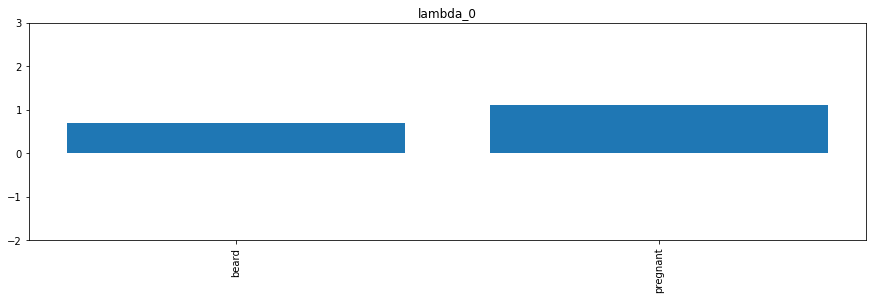

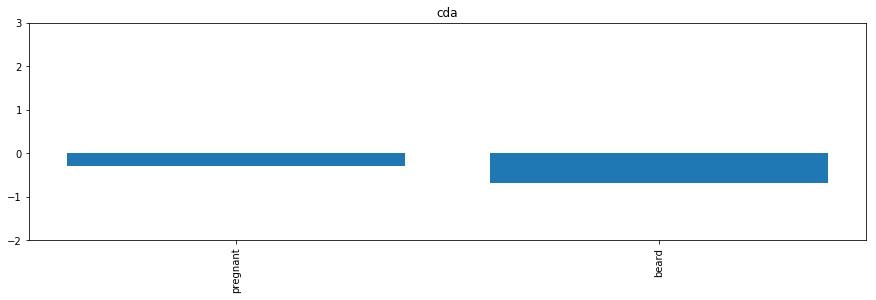

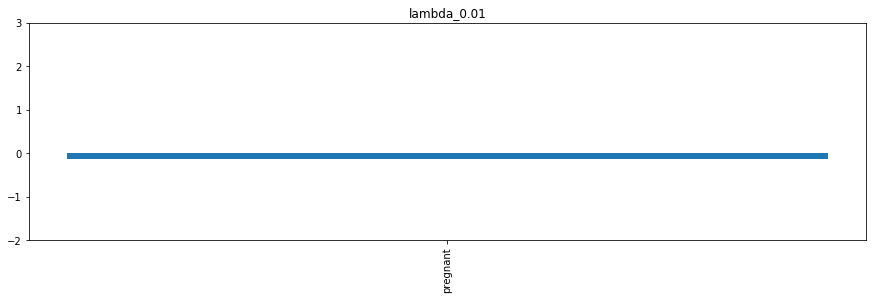

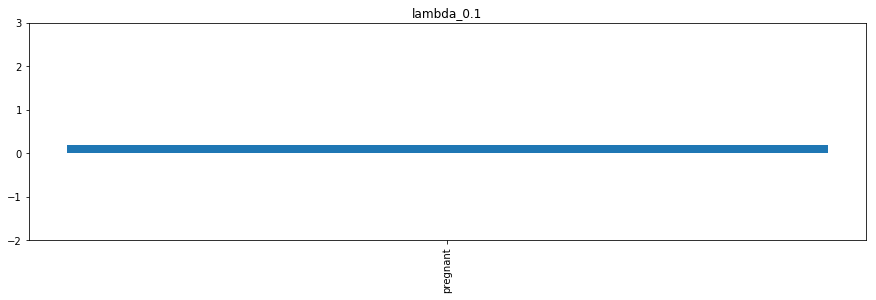

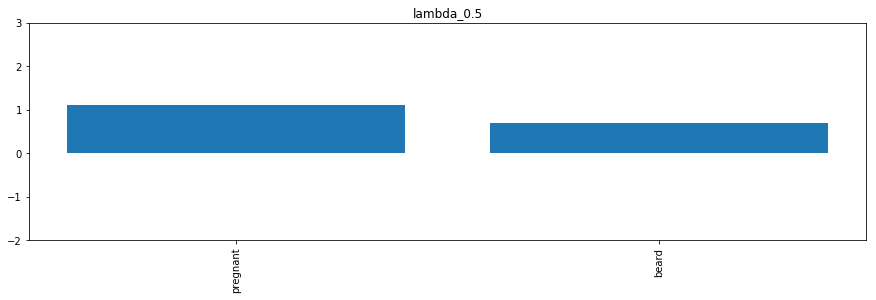

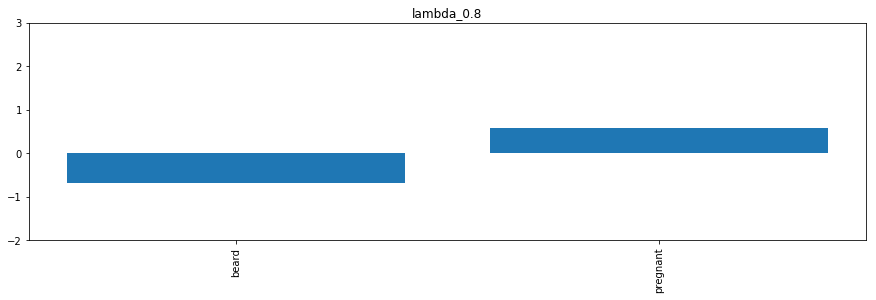

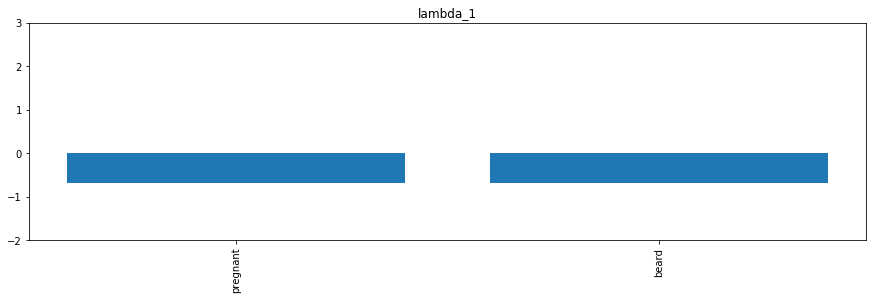

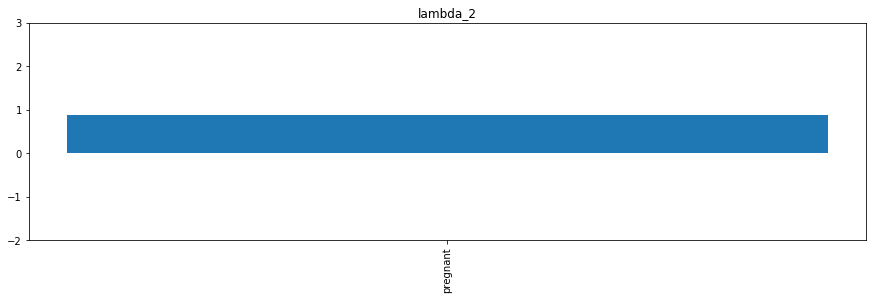

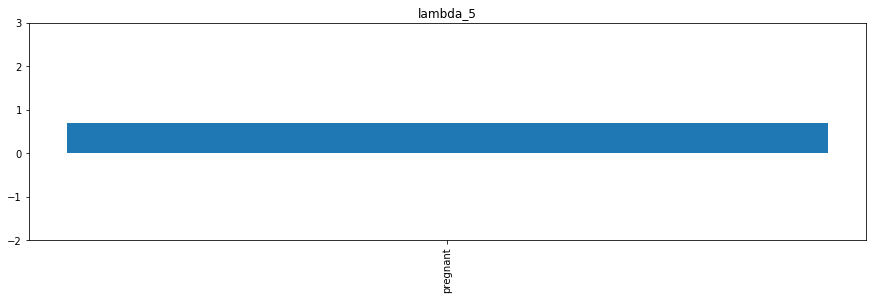

In [30]:
#biasDist
for i in range(len(modelsNames)):
    bdict = scoreDictList[i]
    plt.figure(figsize=(15,4))
    values = [v[0] for v in list(bdict.values())]
    print(list(zip(list(bdict.keys()),[v[1] for v in list(bdict.values())])))
    plt.bar(list(bdict.keys()), values)
    plt.title(modelsNames[i])
    plt.ylim((-2,3))
    _=plt.xticks(list(bdict.keys()), rotation='vertical')